# More Visualizations

From the cnns lecture, our conclusion was that we want to have more visualizations to understand what's going on in our model.

1. Saliency Maps
2. Class
3. t-SNE

In [201]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12, layer0_3x6, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=16, N=20000)

## Saliency Maps

Plan: We did this in pytorch for the 2d images, so this should just involve modifying some code for 3d images! :-)

In [203]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dtype = torch.float32

In [214]:
import tqdm 

def compute_saliency_maps(m, loader):
    """
    Compute a class saliency map using the model for showers in the DataLoader.
    Input:
    - loader: 
    - m: A pretrained model that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the inp
    ut
    images.
    """
    # Make sure the model is in "test" mode
    m.eval()
    
    
    l0_saliencies = []
    l1_saliencies = []
    l2_saliencies = []
    y_test = []
    
    x0 = []
    x1 = []
    x2 = []
    preds = []

    
    for l0, l1, l2, y in tqdm.tqdm(loader):
        
        l0 = l0.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        l1 = l1.to(device=device, dtype=dtype)
        l2 = l2.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        
        l0.requires_grad_()
        l1.requires_grad_()
        l2.requires_grad_()
        
        # forward pass through the model
        scores = m(l0,l1,l2)
        loss = F.cross_entropy(scores, y)
    
        # backward pass: compute the gradients
        loss.backward()
        
        dl0 = l0.grad
        dl1 = l1.grad
        dl2 = l2.grad
    
        l0_saliencies.append(torch.max(torch.abs(dl0),dim=1)[0])
        l1_saliencies.append(torch.max(torch.abs(dl1),dim=1)[0])
        l2_saliencies.append(torch.max(torch.abs(dl2),dim=1)[0])
        y_test.append(y.cpu().numpy())
    
        x0.append(l0.detach().numpy().squeeze())
        x1.append(l1.detach().numpy().squeeze())
        x2.append(l2.detach().numpy().squeeze())
    
        preds.append(np.argmax(scores.detach().numpy(), axis=1))
    

    # Aggregate the info, and return np arrays for plotting purposes :)
    l0_saliencies = np.concatenate(tuple(l0_saliencies),axis=0)
    l1_saliencies = np.concatenate(tuple(l1_saliencies),axis=0)
    l2_saliencies = np.concatenate(tuple(l2_saliencies),axis=0)
    y_test = np.concatenate(tuple(y_test),axis=0)
    x0 = np.concatenate(tuple(x0),axis=0)
    x1 = np.concatenate(tuple(x1),axis=0)
    x2 = np.concatenate(tuple(x2),axis=0)
    preds = np.concatenate(tuple(preds),axis=0)
        
    return l0_saliencies, l1_saliencies, l2_saliencies, y_test, x0, x1, x2, preds
        

Which model should I train this on?
- Plan: Go ahead and just use the fc net for now :)

In [205]:
cnn = CNN_3d(spatialDim=(3,6),preConvParams={'nF':32},
                 nFilters_1=32, filter_1= (3,3,3), stride_1=(1,1,1), padding_1=(1,1,1),
                 nFilters_2=16, filter_2= (3,3,2), stride_2=(2,2,2), padding_2=(1,1,1),
                 h1_dim=150, h2_dim=100)

Output size after the first conv: 32,3.0,3.0,6.0
Output size after the second conv: 16,2.0,2.0,4.0


In [206]:
cnn.modelName[:-8]

'cnn3d_3x6_C32_F333_S111_P111_C16_F332_S222_P111_fc_150_100'

In [207]:
cnn.load_state_dict(torch.load("../models/{}.pt".format(cnn.modelName[:-8])))#,
#                     map_location=lambda storage, location: 'cpu'))

In [215]:
l0_sal, l1_sal, l2_sal, y, x0, x1, x2, preds = compute_saliency_maps(cnn, loader_val)

100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


**Plan:**

Now that we have some saliency maps, what can we *do* with this information?
- We can compare the validation layer images with the saliency maps (this is what we did in the HW)


In [216]:
import matplotlib.pyplot as plt

def show_saliency_maps(l0_map, l1_map, l2_map, x0_img, x1_img, x2_img, title=''):
    '''
    Compare the calorimeter image and saliency map for each layer for a shower.
    
    Inputs:
    - l0_map: saliency map for layer 0
    - l1_map:   "       "   "    "   1
    - l2_map:   "       "   "    "   2
    - x0: calorimeter image in layer 0
    - x1:       "       "   "   "    1
    - x2:       "       "   "   "    2
    - title: The title for the plot!
    '''
    
    # Step 1: Add the mean back to the img (I'll put this in later)
    
    fig = plt.figure(figsize=(6,9))
        
    # Step 3: Loop through the layers and make plots
    for i, x, l in zip(range(3), [x0_img, x1_img, x2_img], [l0_map, l1_map, l2_map]):
                
        # Validation image
        plt.subplot(3,2,i*2+1)
        plt.imshow(x, aspect='auto')
        # Turn off the axis labels
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.ylabel('Layer {}\n$\phi$'.format(i),fontsize=12)
        if i == 0:
            plt.title('Calorimeter Images')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
    
        # Saliency plot
        plt.subplot(3,2,i*2+2)
        plt.imshow(l, cmap=plt.cm.hot, aspect='auto')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if i == 0:
            plt.title('Saliency Maps')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
   
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.925)
    plt.show()

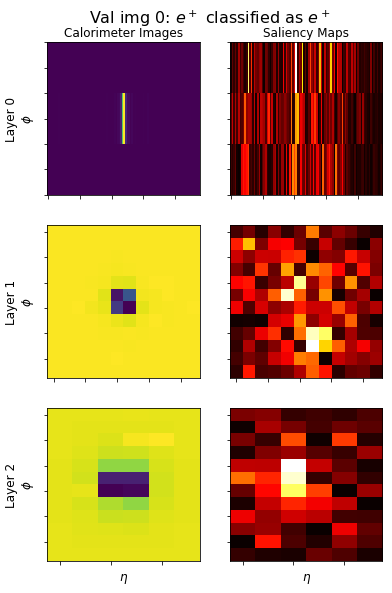

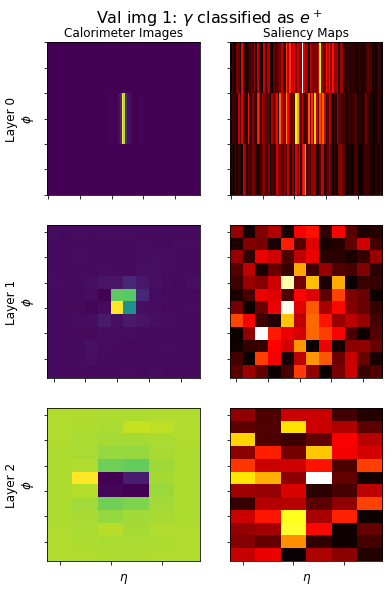

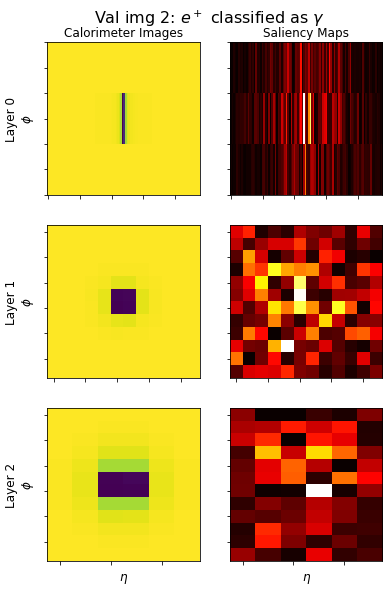

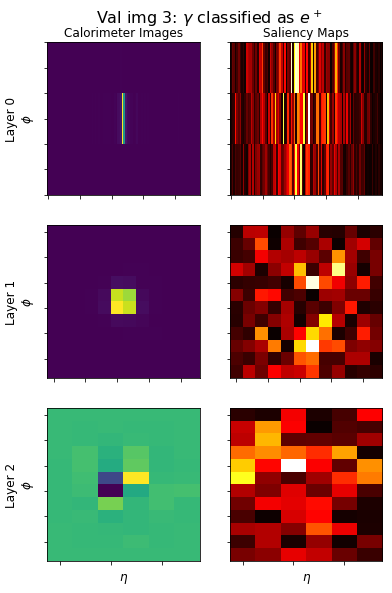

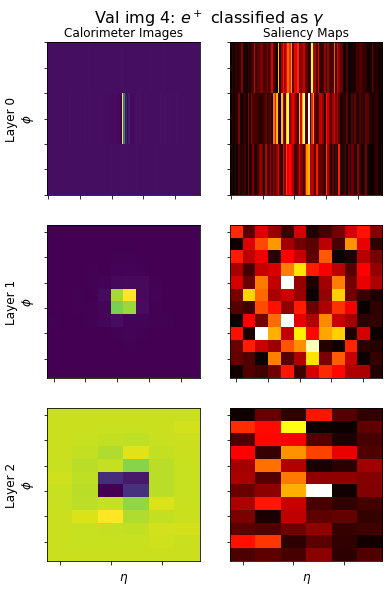

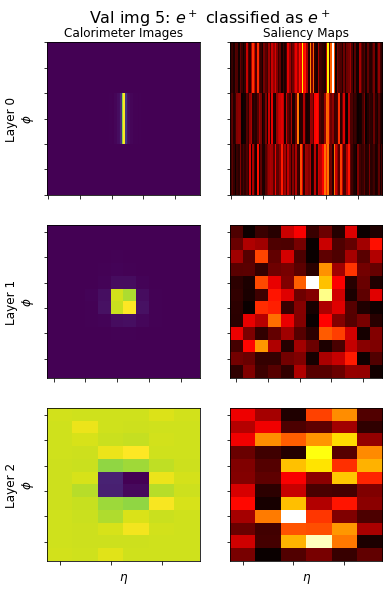

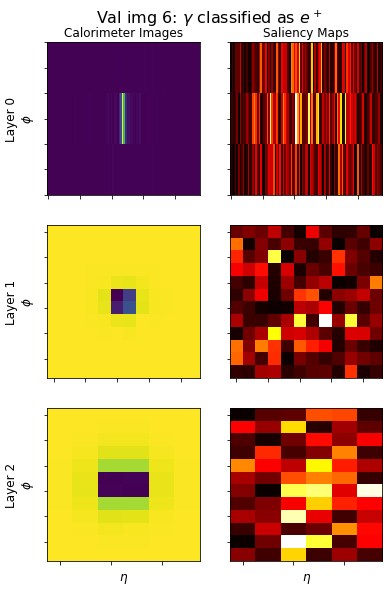

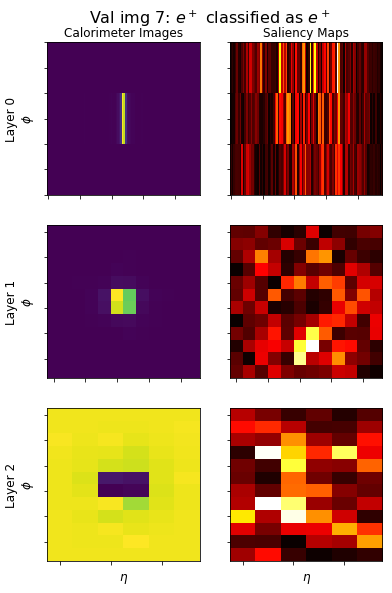

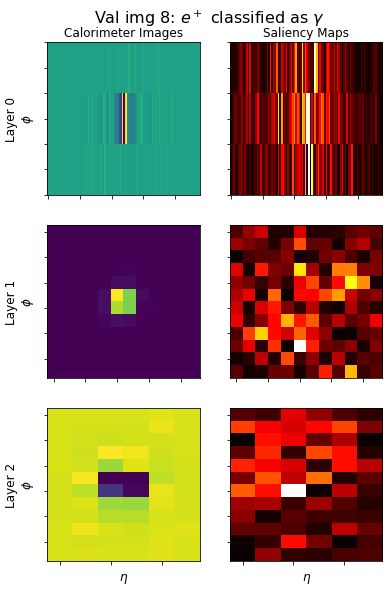

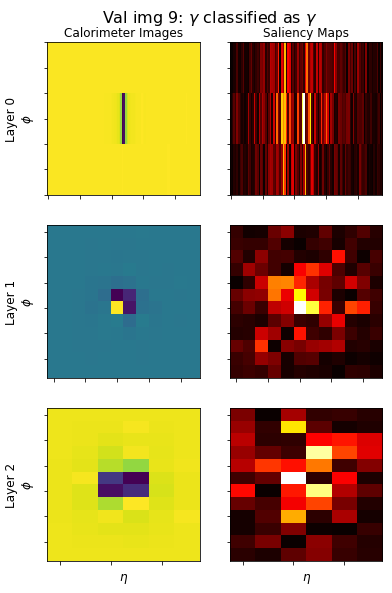

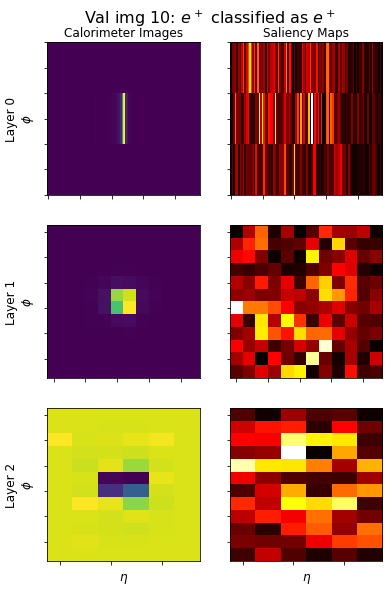

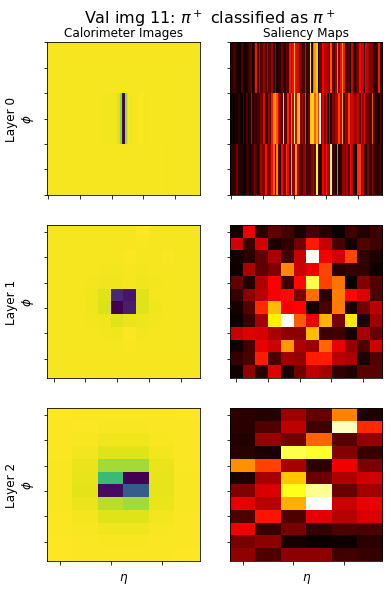

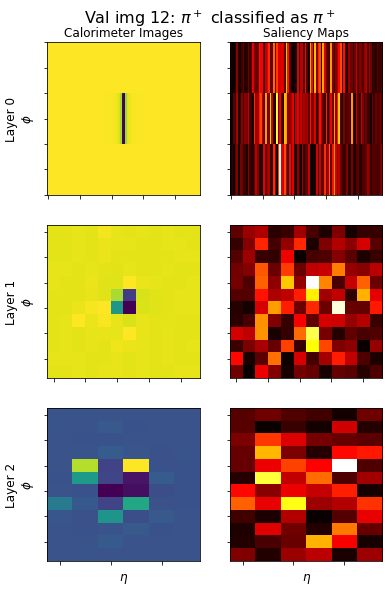

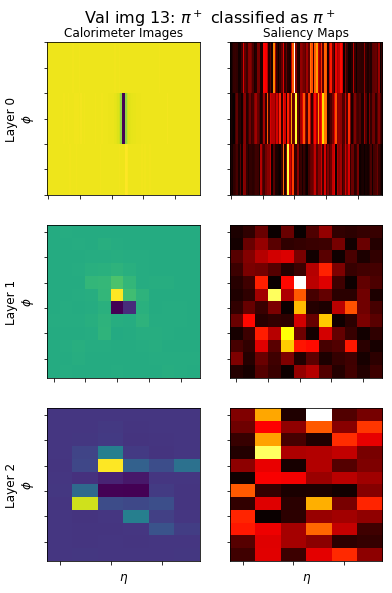

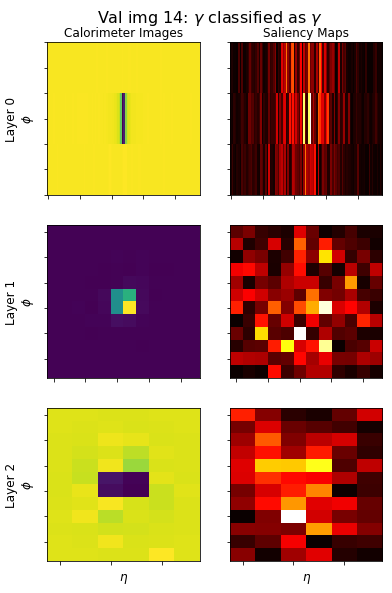

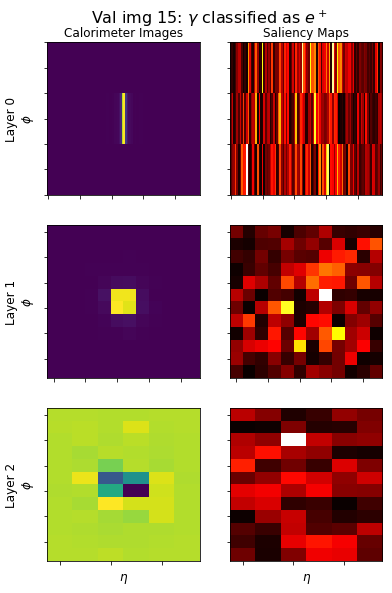

In [217]:
# Ok, let's test it out by look @ the first event
# y_test[0]
# title = ''
for i in range(16):
    pcle = { 0 : '$\gamma$', 
             1 : '$\pi^+$',
             2 : '$e^+$'}
    title = "Val img {}: {} classified as {}\n".format(i, pcle[y[i]], pcle[preds[i]])
    show_saliency_maps(l0_sal[i], l1_sal[i], l2_sal[i], x0[i], x1[i], x2[i], title)

**Next step:**
- Average the saliency plot for each block of the confusion matrix to get some aggregated information about the results from the training.
- Perhaps a good comparison would be the average image for each particle type for the inputs

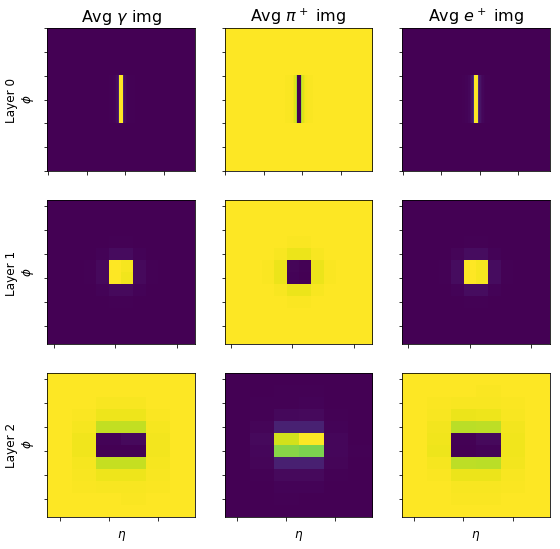

In [ ]:
fig = plt.figure(figsize=(9,9))

for i in range(3):
    
    # layer 0
    plt.subplot(3,3,i+1)
    plt.imshow(x0[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.title('Avg {} img'.format(pcle[i]),fontsize=16)
    
    if i == 0:
        plt.ylabel('Layer 0\n $\phi$',fontsize=12)
    
    # layer 1
    plt.subplot(3,3,4+i)
    plt.imshow(x1[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if i == 0:
        plt.ylabel('Layer 1\n $\phi$',fontsize=12)
    
    
    # layer2
    plt.subplot(3,3,7+i)
    plt.imshow(x2[y==i].mean(axis=0),aspect='auto')
    
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.xlabel('$\eta$',fontsize=12)
    
    if i == 0:
        plt.ylabel('Layer 2\n $\phi$',fontsize=12)

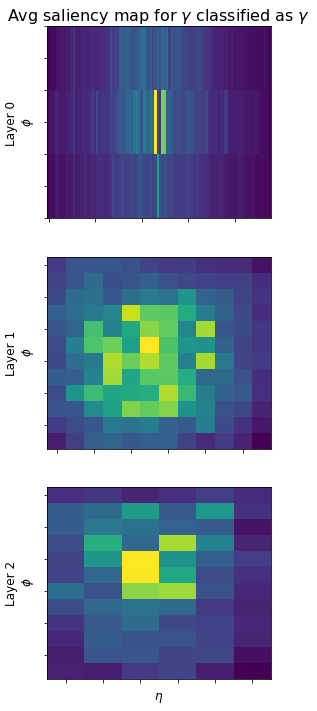

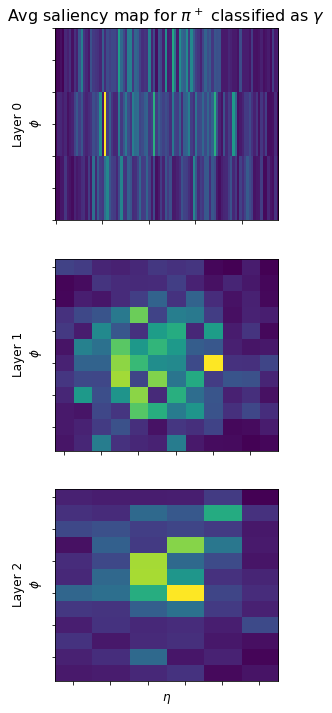

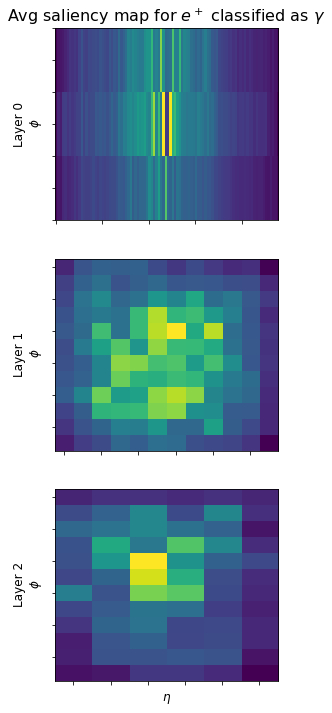

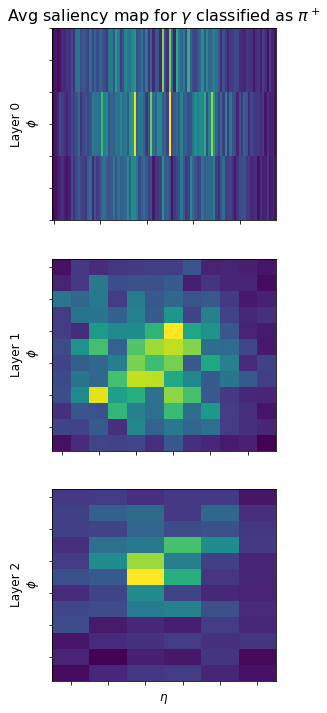

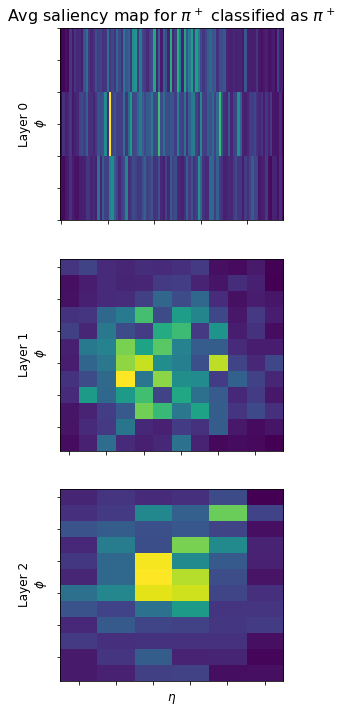

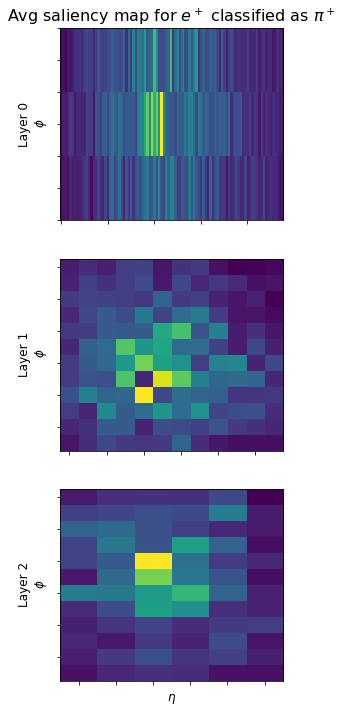

In [ ]:
'''
Loop over the true and predicted particle labels and make the predictions accordingly.
'''

for yi in range(3):
    for pi in range(3):
        
        plt.figure(figsize=(4,12))
        
        # layer 0
        plt.subplot(3,1,1)
        plt.imshow(l0_sal[(y==yi) & (preds==pi)].mean(axis=0),aspect='auto')

        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title('Avg saliency map for {} classified as {}'.format(pcle[pi], pcle[yi]), fontsize=16)
        plt.ylabel('Layer 0\n $\phi$',fontsize=12)

        # layer 1
        plt.subplot(3,1,2)
        plt.imshow(l1_sal[(y==yi) & (preds==pi)].mean(axis=0),aspect='auto')

        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.ylabel('Layer 1\n $\phi$',fontsize=12)


        # layer2
        plt.subplot(3,1,3)
        plt.imshow(l2_sal[(y==yi) & (preds==pi)].mean(axis=0),aspect='auto')

        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.xlabel('$\eta$',fontsize=12)

        plt.ylabel('Layer 2\n $\phi$',fontsize=12)

plt.show()